In [12]:
import numpy as np 
import time
import copy
import os
import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm
import copy
import random

In [13]:
X_train = np.load("../data/X_train.npy", allow_pickle=True) 
y_train = np.load("../data/y_train.npy", allow_pickle=True)
X_valid = np.load("../data/X_valid.npy", allow_pickle=True)
y_valid = np.load("../data/y_valid.npy", allow_pickle=True)

In [14]:
start = time.time() # かかった時間の計測のため計算開始時刻保存
clf = SVC(kernel="linear")
clf.fit(X_train, y_train) # 学習
elapsed_time = time.time() - start # 計算終了時刻から計算時間算出
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:1.9873876571655273[sec]


In [15]:
start = time.time()
predict = clf.predict(X_valid) # 評価用データで予測
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

print("結果")
ac_score = metrics.accuracy_score(y_valid, predict) # 予測結果の答え合わせ
cl_report = metrics.classification_report(y_valid, predict)
print("正解率 = ", ac_score)
print(cl_report)

elapsed_time:0.12532281875610352[sec]
結果
正解率 =  0.978
              precision    recall  f1-score   support

           3       0.99      0.97      0.98       234
           7       0.97      0.99      0.98       266

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



In [16]:
t = 0.5
def K(xa, xb) : return xa.dot(xb.T) 
def delta_kernel(xi, xc) : return t * xi
def delta_q(xi, xc, yi, yc):
    d = xi.shape[1]
    yy = np.array([(yi * yc)] * d).T
    return yy * (delta_kernel(xi, xc))

In [17]:
y_train_ = np.where(y_train == '7', 1, -1)
y_valid_ = np.where(y_valid == '7', 1, -1)
print(y_valid.shape)

(500,)


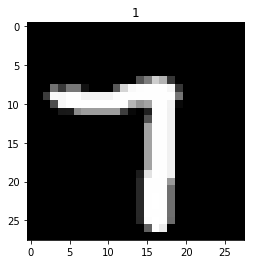

100%|██████████| 200/200 [00:07<00:00, 27.55it/s]


In [18]:
xk = X_valid
yk = y_valid_

initial_idx = 0
xc = X_train[initial_idx, :]
yc = y_train_[initial_idx] * -1

plt.imshow(xc.reshape(28,28),cmap='gray')
plt.title(y_train_[initial_idx])
plt.show()
#---------------------------

num_iteration = 200
train_idx = random.sample(list(range(X_train.shape[0]))
                          , 100)
log = []
X_train_poisoned = copy.copy(X_train[train_idx,:])
y_train_poisoned = copy.copy(y_train_[train_idx])
for i in tqdm(range(num_iteration)):
    
    clf = SVC(kernel="linear", C=1)
    # add poinsoned data
    clf.fit(np.concatenate([X_train_poisoned,
                                       xc.reshape(1, -1)]),
             np.concatenate([y_train_poisoned,
                                       [yc]]))
    log.append(clf.score(xk, yk))
    
    # ------------------------ #
    xs = clf.support_vectors_
    ys = np.concatenate([y_train_poisoned,
                                       [yc]])[clf.support_]
    
    Qks = yk.reshape(-1,1).dot(ys.reshape(-1, 1).T) * K(xk, xs)
    Qss_inv =np.linalg.inv(K(xs, xs))
    v = Qss_inv.dot(ys)
    zeta = ys.T.dot(v)
    Mk = (-1/zeta) *\
         ((Qks)\
          .dot(zeta * Qss_inv - v.dot(v.T))\
          + yk.reshape(-1, 1).dot(v.reshape(1, -1)))
    
    delta_Qsc = delta_q(xs, xc.reshape, ys, yc)
    delta_Qkc  = delta_q(xk, xc.reshape(1, -1), yk, yc)
    
    alpha = clf.decision_function([xc])
    delta_L = np.sum(((Mk.dot(delta_Qsc) + delta_Qkc) * alpha),
                     axis=0)
    u = delta_L / np.sqrt(np.sum((delta_L ** 2)))
    xc += t * u
    
    #X_train_poisoned = np.concatenate([X_train_poisoned,
    #                                   xc.reshape(1, -1)])
    #y_train_poisoned = np.concatenate([y_train_poisoned,
    #                                   [yc]])

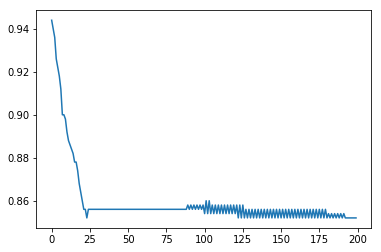

In [19]:
plt.plot(log)

In [9]:
clf = SVC(kernel="linear", C=1)
clf.fit(X_train_poisoned, y_train_poisoned)
clf.score(xk, yk)

0.962

In [20]:
clf = SVC(kernel="linear", C=1)
# add poinsoned data
clf.fit(np.concatenate([X_train_poisoned,
                                       xc.reshape(1, -1)]),
             np.concatenate([y_train_poisoned,
                                       [yc]]))
clf.score(xk, yk)

0.852

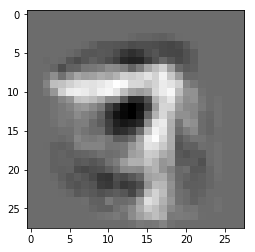

In [21]:
plt.imshow(xc.reshape(28,28),cmap='gray')